<h1>LightMat Tutorial: Density of Bose gas and Fermi gas in arbitrary trap potential</h1>

Before we start, if not done already, create the conda environment using 'conda env create -f environment.yml', then the python kernel 'lightmat' can be selected for this jupyter notebook. Or, alternatively install all required packages using 'pip install -r requirements.txt', then the standard python kernel should have all the necessary packages.

In this tutorial, it is shown how to calculate the spatial density of an atomic gas in some arbitrary potential. This potential could either be a 3d array, for example coming from a LightMat calculation of some LaserSetup (see single atom tutorial) or it could also be just a self-written callable function. 

In [1]:
from LightMat import BoseGas, FermiGas, ParticleProps
import numpy as np
import astropy.units as u
from typing import Union

<h3>Set up a callable potential function</h3>
Let us first discuss how to set up a callable potential function in which the density of some atomic gas should be calculated. As an example, we can just set up a harmonic potential in all 3 directions with some random noise on it to see how it affects the density.

In [2]:
np.random.seed(42)

def harmonic_trap(
        x: Union[float, np.ndarray, u.Quantity],
        y: Union[float, np.ndarray, u.Quantity],
        z: Union[float, np.ndarray, u.Quantity],
        trap_depth: Union[float, u.Quantity] = 200*u.nK,
        waist: Union[float, u.Quantity] = 50*u.um,
        inhomogenity: float = 0,
    ) -> Union[float, np.ndarray]:
    """Return a harmonic trap potential in [k_B x nK] for given position(s) in [μm].
    
        Args:
            x, y, z: position in [μm]. Can either be just scalars or arrays obtained from np.meshgrid().
            trap_depth: trap depth in [k_B x nK]. Defaults to 200nK.
            waist: region in which we can model the trap as harmonic is [-waist, waist] in [μm]. Defaults to 50μm.
            inhomogenity: This number times `trap_depth` gives the noise magnitude. Defaults to 0.

        Returns:
            V(x, y, z): harmonic trap potential in [k_B x nK], array of same shape as x, y, z.
    """
    if isinstance(x, u.Quantity) and x.unit.is_equivalent(u.um):
        x = x.to(u.um).value
    if isinstance(y, u.Quantity) and y.unit.is_equivalent(u.um):
        y = y.to(u.um).value
    if isinstance(z, u.Quantity) and z.unit.is_equivalent(u.um):
        z = z.to(u.um).value
    if isinstance(trap_depth, u.Quantity) and trap_depth.unit.is_equivalent(u.nK):
        trap_depth = trap_depth.to(u.nK).value
    if isinstance(waist, u.Quantity) and waist.unit.is_equivalent(u.um):
        waist = waist.to(u.um).value

    # Create Gaussian profile for isotropc 3d harmonic trap
    r_squared = x**2 + y**2 + z**2
    gaussian_profile = np.exp(-2 * r_squared / waist**2)

    # Apply the potential: -trap_depth at the center, 0 at the edges
    perfect_harmonic_trap = -trap_depth * gaussian_profile

    # Add noise
    noise = np.random.rand(*perfect_harmonic_trap.shape, ) * inhomogenity * trap_depth

    return perfect_harmonic_trap + noise

<h3>Set up particle properties</h3>

Now we want to set up some properties of the particles for which we want to calculate the spatial density. This also includes also the potential that is seen by the particles, for example the harmonic potential defined above. 

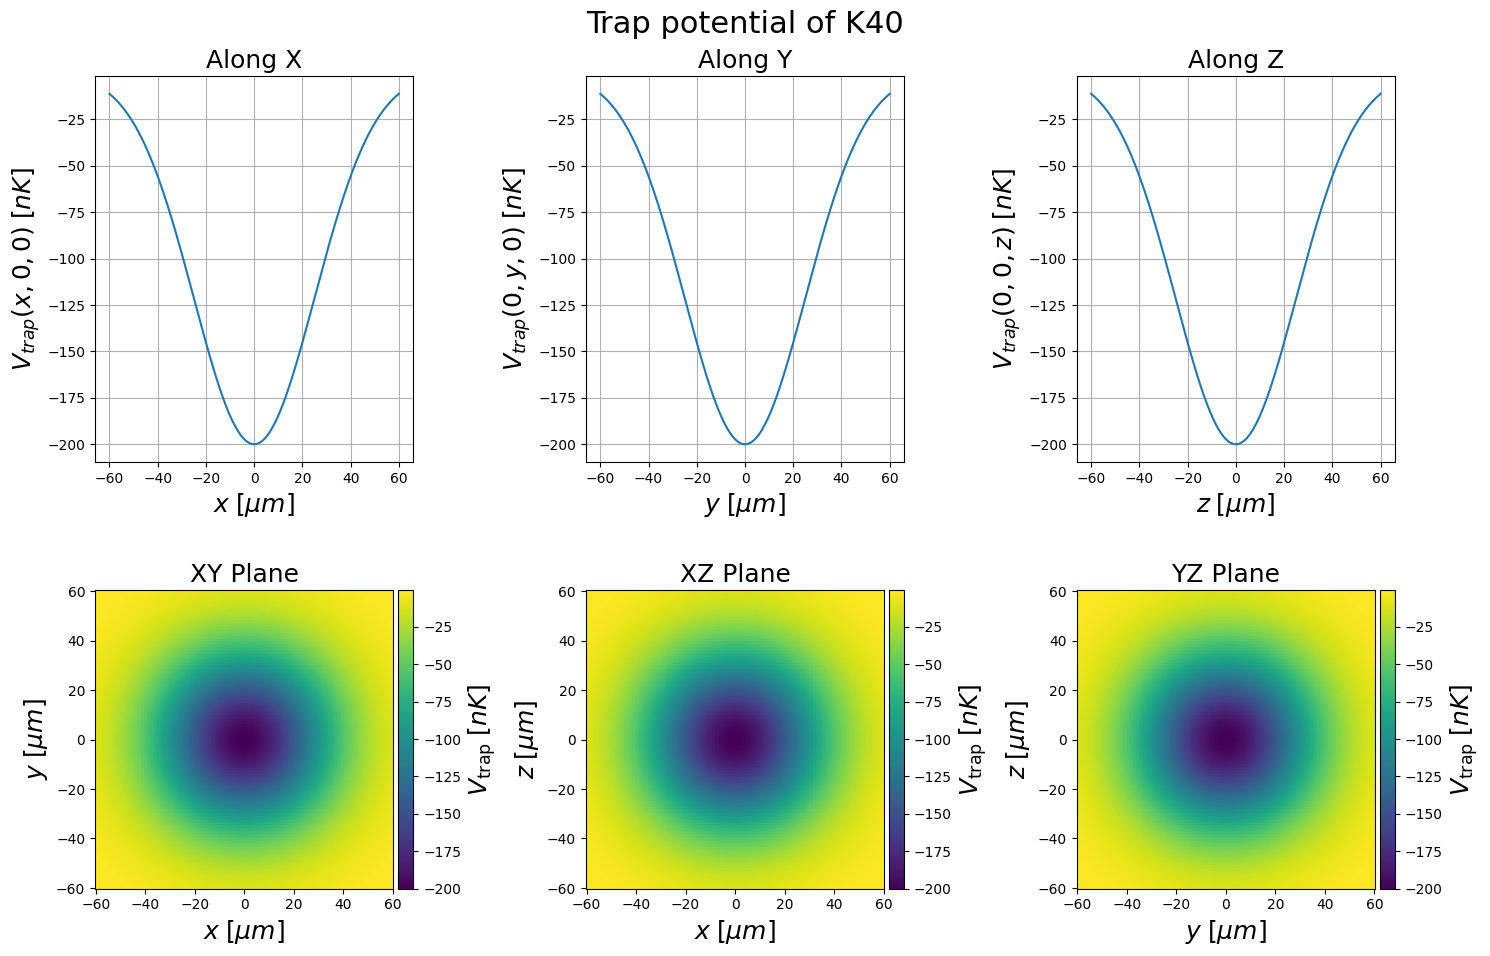

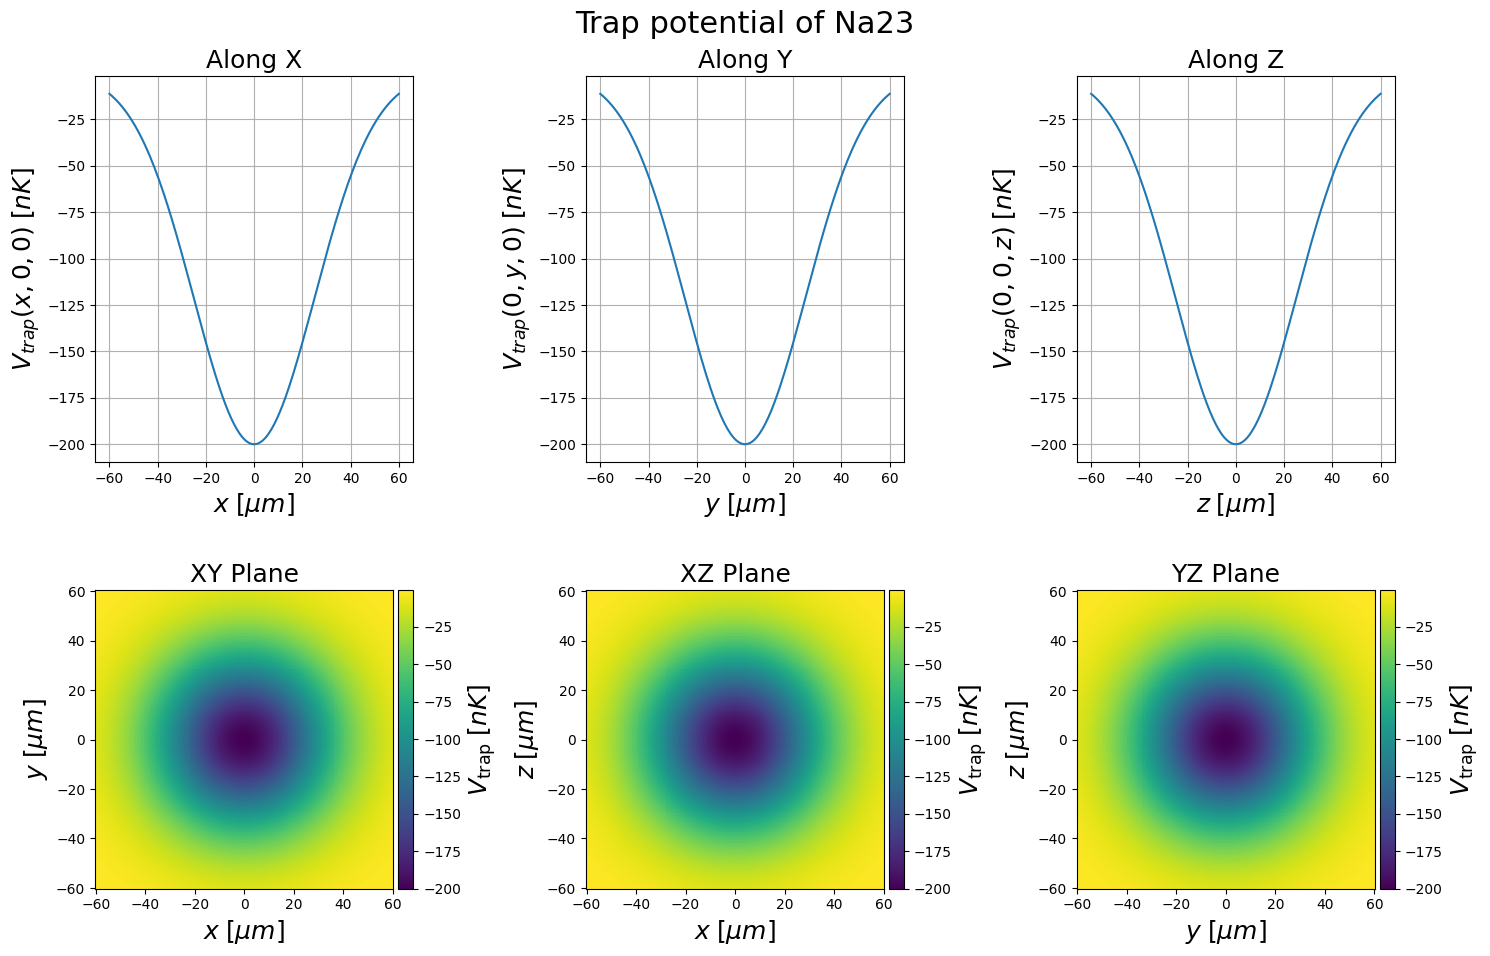

In [3]:
k40_harmonic = ParticleProps(
    name="K40", # this is just a label, it does not need to be provided. Default is "Particle"
    species="fermion", # boson or fermion
    m=39.963999*u.u, # mass of the atomic particles, either as float (assumed to be in [kg]) or as astropy.Quantity in units of mass
    N_particles=100000, # number of particles in the gas. The chemical potential will later be chosen such that the density is normalized to N_particles
    T=0*u.nK, # temperature of the gas, either as float (assumed to be in [nK]) or as astropy.Quantity in units of temperature
    domain=(-60, 60)*u.um, 
    # Specifiy trap with callable trap function and additional kwargs to that function
    V_trap_func=harmonic_trap, 
    trap_depth=200*u.nK, # kwarg of harmonic_trap()
    waist=50*u.um, # kwarg of harmonic_trap()
    inhomogenity=0, # kwarg of harmonic_trap()
)

na23_harmonic = ParticleProps(
    name="Na23",
    species="boson",
    m=22.989768*u.u,
    N_particles=100000,
    T=0*u.nK,
    a_s=2.75*u.nm,
    domain=(-60, 60)*u.um,
    # Specifiy trap with callable trap function and additional kwargs to that function
    V_trap_func=harmonic_trap,
    trap_depth=200*u.nK, # kwarg of harmonic_trap()
    waist=50*u.um, # kwarg of harmonic_trap()
    inhomogenity=0, # kwarg of harmonic_trap()
)

k40_harmonic.plot_V_trap()
na23_harmonic.plot_V_trap()

<h3>Calculate density...</h3>

In [4]:
fg_harmonic = FermiGas(k40_harmonic)
fg_harmonic.eval_density()

bg_harmonic = BoseGas(na23_harmonic)
bg_harmonic.eval_density()

# the array of the density can be found as fg.n_array or bg.n_array (also bg.n0_array and bg.n_ex_array)

Calculate n with TF approximation...


  5%|▌         | 51/1000 [00:01<00:26, 36.05it/s]


Convergence reached after 51 iterations.
Calculate n0 with TF approximation and n_ex with semiclassical HF approximation...


 52%|█████▏    | 52/100 [00:02<00:02, 21.91it/s]

Convergence reached after 52 iterations.


<h3>Plot density</h3>

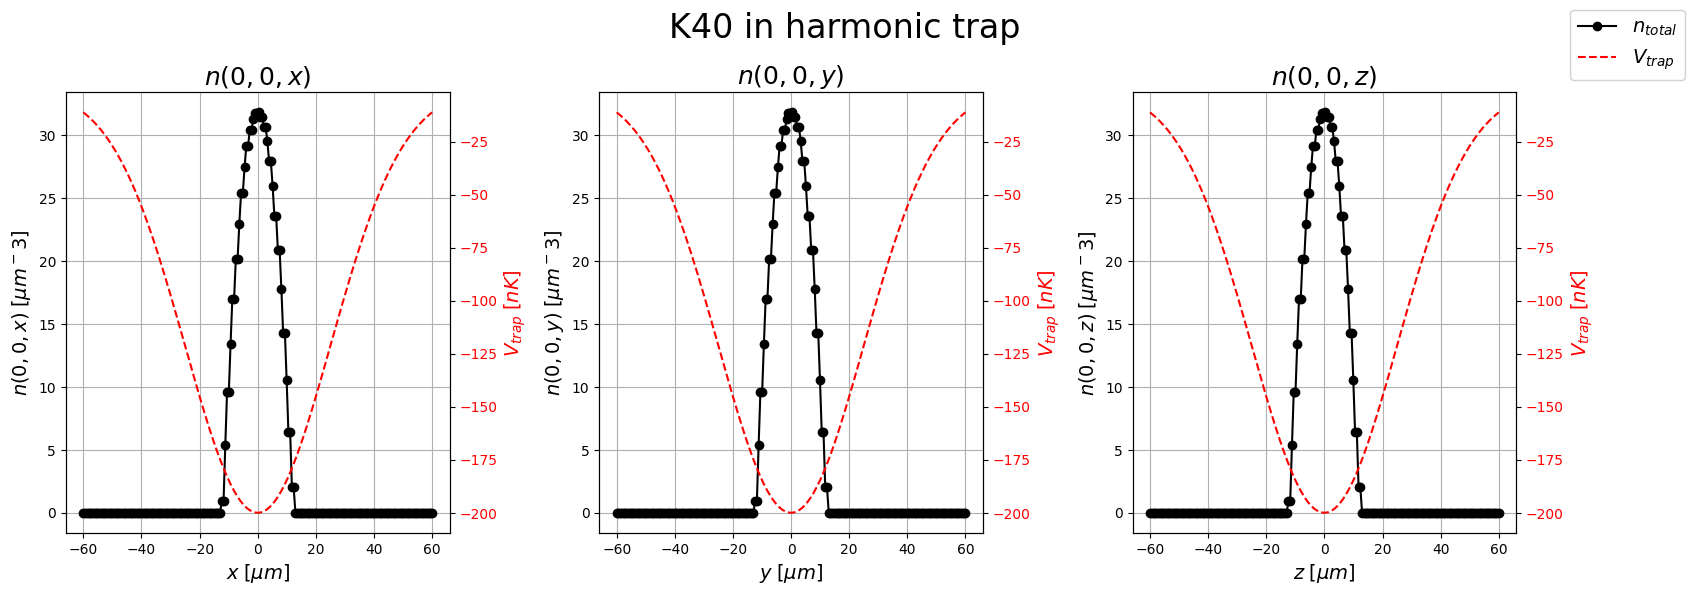

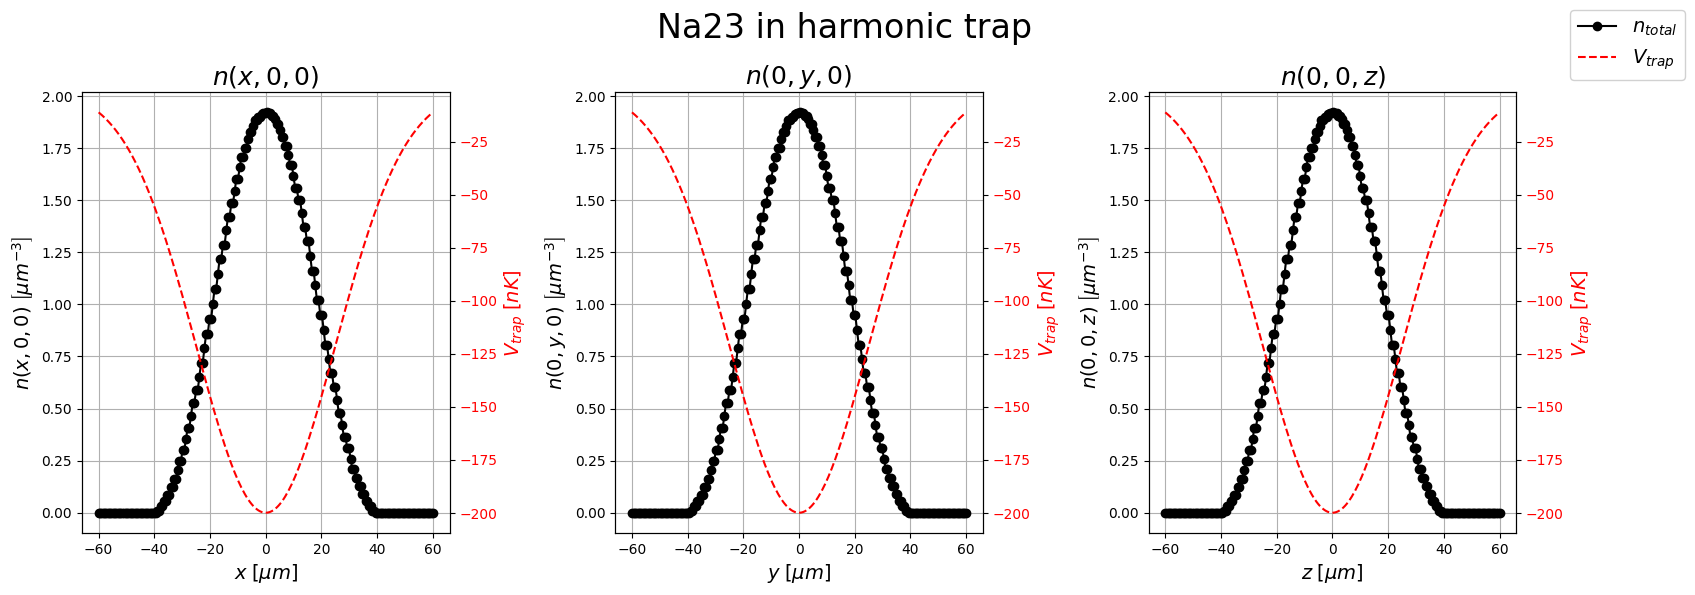

In [5]:
fig_bg = bg_harmonic.plot_density_1d(which='n', title="K40 in harmonic trap")
fig_fg = fg_harmonic.plot_density_1d(title="Na23 in harmonic trap")

<h3>Chemical potential</h3>

In [6]:
print('Chemical potential of K40 in harmonic trap: μ =', bg_harmonic.mu)
print('Chemical potential of Na23 in harmonic trap: μ =', fg_harmonic.mu)

Chemical potential of K40 in harmonic trap: μ = -176.73639468468318 nK
Chemical potential of Na23 in harmonic trap: μ = -57.41324718529709 nK
